In [ ]:
# If needed, uncomment to install deps
# !pip install -q transformers timm tifffile

import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import tifffile as tiff
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation

# Colab: mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/drive/MyDrive/Dataset/Dataset.zip"
extract_dir = "/content/Dataset"   # where you want to unzip

# Make sure output dir exists
os.makedirs(extract_dir, exist_ok=True)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Dataset extracted to: {extract_dir}")

# Paths after extraction
images_path = os.path.join(extract_dir, "Dataset", "Images")
masks_path  = os.path.join(extract_dir, "Dataset", "Mask")

# Quick check
print("\nSample files:")
print("Images:", os.listdir(images_path)[:5])
print("Masks:", os.listdir(masks_path)[:5])


✅ Dataset extracted to: /content/Dataset

Sample files:
Images: ['Image_057.tif', 'Image_053.tif', 'Image_200.tif', 'Image_181.tif', 'Image_127.tif']
Masks: ['Mask_018.tif', 'Mask_205.tif', 'Mask_221.tif', 'Mask_016.tif', 'Mask_044.tif']


In [ ]:
# Your structure:
IMAGES_DIR = "/content/Dataset/Dataset/Images"
MASKS_DIR  = "/content/Dataset/Dataset/Mask"

import os

assert os.path.isdir(IMAGES_DIR), f"❌ Images dir not found: {IMAGES_DIR}"
assert os.path.isdir(MASKS_DIR),  f"❌ Masks dir not found: {MASKS_DIR}"

print("✅ Both Images and Masks directories found!")


✅ Both Images and Masks directories found!


In [ ]:
import os

root_dir = "/content/Dataset/Dataset"  # after extraction

print("Root contents:", os.listdir(root_dir))

if "Images" in os.listdir(root_dir):
    print("Images folder contents:", os.listdir(os.path.join(root_dir, "Images"))[:10])
if "Mask" in os.listdir(root_dir):
    print("Mask folder contents:", os.listdir(os.path.join(root_dir, "Mask"))[:10])


Root contents: ['Mask', 'Images']
Images folder contents: ['Image_057.tif', 'Image_053.tif', 'Image_200.tif', 'Image_181.tif', 'Image_127.tif', 'Image_231.tif', 'Image_099.tif', 'Image_049.tif', 'Image_208.tif', 'Image_143.tif']
Mask folder contents: ['Mask_018.tif', 'Mask_205.tif', 'Mask_221.tif', 'Mask_016.tif', 'Mask_044.tif', 'Mask_069.tif', 'Mask_146.tif', 'Mask_207.tif', 'Mask_219.tif', 'Mask_222.tif']


In [ ]:
# ================================
# Dataset Definition (with ID matching)
# ================================
from torch.utils.data import Dataset
from PIL import Image
import os, re
import numpy as np
import torch
from transformers import SegformerFeatureExtractor

# SegFormer processor (resize to 512x512)
processor = SegformerFeatureExtractor(do_resize=True, size=512)

def extract_number(filename):
    """Extract first number from filename, e.g. 'Image_35.tif' -> 35"""
    nums = re.findall(r'\d+', filename)
    return int(nums[0]) if nums else -1

class LULCDataset(Dataset):
    def __init__(self, image_dir, mask_dir, processor):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.processor = processor

        valid_exts = ('.png', '.jpg', '.jpeg', '.tif')

        # Map files by number
        images = {extract_number(f): f for f in os.listdir(image_dir) if f.lower().endswith(valid_exts)}
        masks  = {extract_number(f): f for f in os.listdir(mask_dir) if f.lower().endswith(valid_exts)}

        # Keep only IDs that exist in both
        common_ids = sorted(set(images.keys()) & set(masks.keys()))

        self.pairs = [(images[i], masks[i]) for i in common_ids]

        assert len(self.pairs) > 0, "❌ No matching image-mask pairs found!"

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_file, mask_file = self.pairs[idx]

        img_path  = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        # Open image (RGB) and mask (grayscale)
        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")

        # Apply processor (resize to 512x512)
        encoded_inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = encoded_inputs["pixel_values"].squeeze(0)  # [3, 512, 512]

        # Resize mask to 512x512 (nearest-neighbor)
        mask = mask.resize((512, 512), resample=Image.NEAREST)
        mask = torch.tensor(np.array(mask), dtype=torch.long)  # [512, 512]

        return pixel_values, mask


/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


cheching the sequence

In [ ]:
IMAGES_DIR = "/content/Dataset/Dataset/Images"
MASKS_DIR  = "/content/Dataset/Dataset/Mask"

dataset = LULCDataset(IMAGES_DIR, MASKS_DIR, processor)

print(f"✅ Dataset loaded with {len(dataset)} pairs")

# Show first 5 pairs to confirm correct matching
for i in range(5):
    img_file, mask_file = dataset.pairs[i]
    print(f"Pair {i}: {img_file}  <->  {mask_file}")


✅ Dataset loaded with 232 pairs
Pair 0: Image_001.tif  <->  Mask_001.tif
Pair 1: Image_002.tif  <->  Mask_002.tif
Pair 2: Image_003.tif  <->  Mask_003.tif
Pair 3: Image_004.tif  <->  Mask_004.tif
Pair 4: Image_005.tif  <->  Mask_005.tif


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=512, num_classes=4, normalize=True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])
        self.mask_files  = sorted([f for f in os.listdir(masks_dir)  if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])

        assert len(self.image_files) == len(self.mask_files), f"Images({len(self.image_files)}) != Masks({len(self.mask_files)})"
        self.image_size = image_size
        self.num_classes = num_classes
        self.normalize = normalize
        # ImageNet mean/std (SegFormer preproc defaults)
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(3,1,1)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(3,1,1)

    def __len__(self):
        return len(self.image_files)

    def _read_image(self, path):
        if path.lower().endswith(('.tif','.tiff')):
            arr = tiff.imread(path)          # may be float, extra dims
        else:
            arr = np.array(Image.open(path)) # HWC

        arr = np.squeeze(arr)
        # Scale non-uint8 to 0..255
        if arr.dtype != np.uint8:
            arr = (255 * (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)).astype(np.uint8)
        # Grayscale → RGB
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)
        return arr  # HWC uint8

    def _read_mask(self, path):
        if path.lower().endswith(('.tif','.tiff')):
            arr = tiff.imread(path)
        else:
            arr = np.array(Image.open(path))
        arr = np.squeeze(arr)
        if arr.ndim == 3:
            arr = arr[:, :, 0]
        return arr  # HW (integers)

    def __getitem__(self, idx):
        img_path  = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir,  self.mask_files[idx])

        # ---- Image ----
        img = self._read_image(img_path)
        img = Image.fromarray(img).resize((self.image_size, self.image_size), resample=Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0        # [0,1]
        img = np.transpose(img, (2, 0, 1))                   # C,H,W
        if self.normalize:
            img = (img - self.mean) / self.std

        # ---- Mask ----
        mask = self._read_mask(mask_path)
        mask = Image.fromarray(mask).resize((self.image_size, self.image_size), resample=Image.NEAREST)
        mask = np.array(mask, dtype=np.int64)
        # Remap anything >=4 to class 3 ("Others")
        mask[mask >= self.num_classes] = self.num_classes - 1

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)


In [ ]:
full_dataset = SegmentationDataset(IMAGES_DIR, MASKS_DIR, image_size=512, num_classes=4)

# 80/20 split
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
xb, yb = next(iter(train_loader))
print("Batch shapes -> images:", tuple(xb.shape), "masks:", tuple(yb.shape))  # expect [B,3,512,512], [B,512,512]


Train samples: 185, Val samples: 47
Batch shapes -> images: (4, 3, 512, 512) masks: (4, 512, 512)


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# id2label = {0:"Urban", 1:"Water", 2:"Vegetation", 3:"Others"}
# label2id = {v:k for k,v in id2label.items()}

# model = SegformerForSemanticSegmentation.from_pretrained(
#     # "nvidia/segformer-b0-finetuned-ade-512-512",
#     "nvidia/segformer-b2-finetuned-ade-512-512",
#     num_labels=4,
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes=True,  # new head (4 classes) initialized
# )
# model.to(device)

# # Optim & training settings
# optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
# num_epochs = 30


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([4, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def pixel_accuracy(preds, labels):
    # preds: [B,H,W] (class ids), labels: [B,H,W]
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

def mean_iou(preds, labels, num_classes=4):
    # preds, labels: [B,H,W]
    ious = []
    for cls in range(num_classes):
        pred_c = (preds == cls)
        label_c = (labels == cls)
        inter = (pred_c & label_c).sum().item()
        union = (pred_c | label_c).sum().item()
        if union == 0:
            ious.append(float("nan"))  # ignore if class not present in both
        else:
            ious.append(inter / union)
    return np.nanmean(ious)


In [ ]:
print(f"Train samples: {len(train_dataset)} ({len(train_loader)} batches of size {BATCH_SIZE})")
print(f"Val samples:   {len(val_dataset)} ({len(val_loader)} batches of size {BATCH_SIZE})")


Train samples: 185 (47 batches of size 4)
Val samples:   47 (12 batches of size 4)


In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_ious, val_ious = [], []

for epoch in range(1, num_epochs+1):
    # ---- Train ----
    model.train()
    tr_loss, tr_acc, tr_iou = 0.0, 0.0, 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)

        # out = model(pixel_values=imgs, labels=masks)   # CrossEntropy inside
        # loss = out.loss
        # logits = out.logits                            # [B, num_classes, H, W]
        logits = model(imgs)  # [B, num_classes, H, W]
        loss = torch.nn.functional.cross_entropy(logits, masks)

        preds = torch.argmax(logits, dim=1)            # [B,H,W]

        # Resize predictions to match mask size for metric calculation
        # preds_resized = torch.nn.functional.interpolate(preds.unsqueeze(1).float(),
        #                                                 size=masks.shape[-2:],
        #                                                 mode='nearest').squeeze(1).long()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        tr_acc  += pixel_accuracy(preds, masks) # Use original preds for metric calculation
        tr_iou  += mean_iou(preds, masks, num_classes=4) # Use original preds for metric calculation

    tr_loss /= len(train_loader)
    tr_acc  /= len(train_loader)
    tr_iou  /= len(train_loader)

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    train_ious.append(tr_iou)

    # ---- Validate ----
    model.eval()
    va_loss, va_acc, va_iou = 0.0, 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validating"):
            imgs, masks = imgs.to(device), masks.to(device)
            # out = model(pixel_values=imgs, labels=masks)
            # va_loss += out.loss.item()

            logits = model(imgs)
            va_loss += torch.nn.functional.cross_entropy(logits, masks).item()


            preds = torch.argmax(logits, dim=1)
            # Resize predictions to match mask size for metric calculation
            # preds_resized = torch.nn.functional.interpolate(preds.unsqueeze(1).float(),
            #                                                 size=masks.shape[-2:],
            #                                                 mode='nearest').squeeze(1).long()

            va_acc += pixel_accuracy(preds, masks) # Use original preds for metric calculation
            va_iou += mean_iou(preds, masks, num_classes=4) # Use original preds for metric calculation

    va_loss /= len(val_loader)
    va_acc  /= len(val_loader)
    va_iou  /= len(val_loader)

    val_losses.append(va_loss)
    val_accs.append(va_acc)
    val_ious.append(va_iou)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {tr_loss:.4f}  Val Loss: {va_loss:.4f}  |  "
          f"Train Acc: {tr_acc*100:.2f}%  Val Acc: {va_acc*100:.2f}%  |  "
          f"Train mIoU: {tr_iou:.4f}  Val mIoU: {va_iou:.4f}")

Validating: 100%|██████████| 12/12 [00:01<00:00,  6.97it/s]


Epoch 1/100 | Train Loss: 0.7208  Val Loss: 0.6573  |  Train Acc: 64.74%  Val Acc: 66.75%  |  Train mIoU: 0.2876  Val mIoU: 0.3711


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]


Epoch 2/100 | Train Loss: 0.5775  Val Loss: 0.5538  |  Train Acc: 72.47%  Val Acc: 73.39%  |  Train mIoU: 0.4354  Val mIoU: 0.4966


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.77it/s]


Epoch 3/100 | Train Loss: 0.5447  Val Loss: 0.5285  |  Train Acc: 72.69%  Val Acc: 74.00%  |  Train mIoU: 0.4562  Val mIoU: 0.5561


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.29it/s]


Epoch 4/100 | Train Loss: 0.5236  Val Loss: 0.5089  |  Train Acc: 74.04%  Val Acc: 74.37%  |  Train mIoU: 0.4886  Val mIoU: 0.5556


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.05it/s]


Epoch 5/100 | Train Loss: 0.4958  Val Loss: 0.5088  |  Train Acc: 75.02%  Val Acc: 73.51%  |  Train mIoU: 0.5248  Val mIoU: 0.5617


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.17it/s]


Epoch 6/100 | Train Loss: 0.4787  Val Loss: 0.4809  |  Train Acc: 75.67%  Val Acc: 75.31%  |  Train mIoU: 0.5280  Val mIoU: 0.5807


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.21it/s]


Epoch 7/100 | Train Loss: 0.4600  Val Loss: 0.4934  |  Train Acc: 77.41%  Val Acc: 75.10%  |  Train mIoU: 0.5606  Val mIoU: 0.5791


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.88it/s]


Epoch 8/100 | Train Loss: 0.4603  Val Loss: 0.4746  |  Train Acc: 77.57%  Val Acc: 76.04%  |  Train mIoU: 0.5670  Val mIoU: 0.5935


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]


Epoch 9/100 | Train Loss: 0.4510  Val Loss: 0.4647  |  Train Acc: 77.70%  Val Acc: 76.37%  |  Train mIoU: 0.5583  Val mIoU: 0.6001


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.94it/s]


Epoch 10/100 | Train Loss: 0.4443  Val Loss: 0.4675  |  Train Acc: 78.21%  Val Acc: 76.07%  |  Train mIoU: 0.5687  Val mIoU: 0.5946


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.06it/s]


Epoch 11/100 | Train Loss: 0.4370  Val Loss: 0.4670  |  Train Acc: 78.81%  Val Acc: 76.09%  |  Train mIoU: 0.5738  Val mIoU: 0.5953


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.95it/s]


Epoch 12/100 | Train Loss: 0.4381  Val Loss: 0.4661  |  Train Acc: 78.52%  Val Acc: 76.05%  |  Train mIoU: 0.5818  Val mIoU: 0.5974


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.12it/s]


Epoch 13/100 | Train Loss: 0.4355  Val Loss: 0.4680  |  Train Acc: 78.57%  Val Acc: 75.95%  |  Train mIoU: 0.5798  Val mIoU: 0.5963


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.05it/s]


Epoch 14/100 | Train Loss: 0.4282  Val Loss: 0.4617  |  Train Acc: 79.40%  Val Acc: 76.17%  |  Train mIoU: 0.5824  Val mIoU: 0.5969


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.09it/s]


Epoch 15/100 | Train Loss: 0.4161  Val Loss: 0.4612  |  Train Acc: 79.88%  Val Acc: 76.29%  |  Train mIoU: 0.6000  Val mIoU: 0.6079


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.01it/s]


Epoch 16/100 | Train Loss: 0.4169  Val Loss: 0.4591  |  Train Acc: 79.76%  Val Acc: 76.54%  |  Train mIoU: 0.5957  Val mIoU: 0.6072


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.01it/s]


Epoch 17/100 | Train Loss: 0.4101  Val Loss: 0.4685  |  Train Acc: 80.34%  Val Acc: 76.28%  |  Train mIoU: 0.6062  Val mIoU: 0.5986


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.11it/s]


Epoch 18/100 | Train Loss: 0.4160  Val Loss: 0.4505  |  Train Acc: 79.89%  Val Acc: 77.19%  |  Train mIoU: 0.5963  Val mIoU: 0.6141


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


Epoch 19/100 | Train Loss: 0.4000  Val Loss: 0.4572  |  Train Acc: 80.86%  Val Acc: 76.95%  |  Train mIoU: 0.6237  Val mIoU: 0.6104


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.05it/s]


Epoch 20/100 | Train Loss: 0.3929  Val Loss: 0.4459  |  Train Acc: 81.25%  Val Acc: 77.85%  |  Train mIoU: 0.6330  Val mIoU: 0.6193


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.11it/s]


Epoch 21/100 | Train Loss: 0.3937  Val Loss: 0.4504  |  Train Acc: 81.27%  Val Acc: 77.52%  |  Train mIoU: 0.6455  Val mIoU: 0.6137


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.03it/s]


Epoch 22/100 | Train Loss: 0.3912  Val Loss: 0.4497  |  Train Acc: 81.34%  Val Acc: 77.48%  |  Train mIoU: 0.6331  Val mIoU: 0.6169


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.98it/s]


Epoch 23/100 | Train Loss: 0.3802  Val Loss: 0.4431  |  Train Acc: 82.16%  Val Acc: 77.67%  |  Train mIoU: 0.6378  Val mIoU: 0.6182


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.13it/s]


Epoch 24/100 | Train Loss: 0.3774  Val Loss: 0.4545  |  Train Acc: 82.27%  Val Acc: 76.86%  |  Train mIoU: 0.6586  Val mIoU: 0.6130


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.16it/s]


Epoch 25/100 | Train Loss: 0.3835  Val Loss: 0.4558  |  Train Acc: 81.87%  Val Acc: 77.04%  |  Train mIoU: 0.6439  Val mIoU: 0.6128


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.14it/s]


Epoch 26/100 | Train Loss: 0.3754  Val Loss: 0.4667  |  Train Acc: 82.40%  Val Acc: 76.68%  |  Train mIoU: 0.6653  Val mIoU: 0.6070


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


Epoch 27/100 | Train Loss: 0.3685  Val Loss: 0.4509  |  Train Acc: 82.76%  Val Acc: 77.26%  |  Train mIoU: 0.6739  Val mIoU: 0.6139


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.99it/s]


Epoch 28/100 | Train Loss: 0.3721  Val Loss: 0.4506  |  Train Acc: 82.54%  Val Acc: 77.71%  |  Train mIoU: 0.6732  Val mIoU: 0.6211


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.00it/s]


Epoch 29/100 | Train Loss: 0.3684  Val Loss: 0.4500  |  Train Acc: 82.85%  Val Acc: 77.42%  |  Train mIoU: 0.6824  Val mIoU: 0.6182


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


Epoch 30/100 | Train Loss: 0.3653  Val Loss: 0.4505  |  Train Acc: 82.95%  Val Acc: 77.34%  |  Train mIoU: 0.6840  Val mIoU: 0.6161


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.04it/s]


Epoch 31/100 | Train Loss: 0.3639  Val Loss: 0.4493  |  Train Acc: 82.93%  Val Acc: 77.52%  |  Train mIoU: 0.6962  Val mIoU: 0.6197


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]


Epoch 32/100 | Train Loss: 0.3532  Val Loss: 0.4512  |  Train Acc: 83.72%  Val Acc: 77.72%  |  Train mIoU: 0.7092  Val mIoU: 0.6228


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.67it/s]


Epoch 33/100 | Train Loss: 0.3498  Val Loss: 0.4566  |  Train Acc: 83.85%  Val Acc: 77.41%  |  Train mIoU: 0.7012  Val mIoU: 0.6202


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.28it/s]


Epoch 34/100 | Train Loss: 0.3502  Val Loss: 0.4573  |  Train Acc: 83.85%  Val Acc: 77.54%  |  Train mIoU: 0.6937  Val mIoU: 0.6201


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.59it/s]


Epoch 35/100 | Train Loss: 0.3494  Val Loss: 0.4526  |  Train Acc: 83.95%  Val Acc: 77.68%  |  Train mIoU: 0.6917  Val mIoU: 0.6215


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.36it/s]


Epoch 36/100 | Train Loss: 0.3437  Val Loss: 0.4558  |  Train Acc: 84.21%  Val Acc: 77.27%  |  Train mIoU: 0.6966  Val mIoU: 0.6192


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.01it/s]


Epoch 37/100 | Train Loss: 0.3470  Val Loss: 0.4504  |  Train Acc: 83.99%  Val Acc: 77.51%  |  Train mIoU: 0.7034  Val mIoU: 0.6206


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]


Epoch 38/100 | Train Loss: 0.3442  Val Loss: 0.4596  |  Train Acc: 84.11%  Val Acc: 77.57%  |  Train mIoU: 0.7120  Val mIoU: 0.6178


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.15it/s]


Epoch 39/100 | Train Loss: 0.3450  Val Loss: 0.4544  |  Train Acc: 84.15%  Val Acc: 77.61%  |  Train mIoU: 0.7042  Val mIoU: 0.6212


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.97it/s]


Epoch 40/100 | Train Loss: 0.3427  Val Loss: 0.4600  |  Train Acc: 84.28%  Val Acc: 77.49%  |  Train mIoU: 0.7149  Val mIoU: 0.6210


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.32it/s]


Epoch 41/100 | Train Loss: 0.3504  Val Loss: 0.4564  |  Train Acc: 83.68%  Val Acc: 77.92%  |  Train mIoU: 0.6985  Val mIoU: 0.6225


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]


Epoch 42/100 | Train Loss: 0.3413  Val Loss: 0.4565  |  Train Acc: 84.31%  Val Acc: 77.62%  |  Train mIoU: 0.7158  Val mIoU: 0.6204


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.92it/s]


Epoch 43/100 | Train Loss: 0.3430  Val Loss: 0.4598  |  Train Acc: 84.25%  Val Acc: 77.61%  |  Train mIoU: 0.7098  Val mIoU: 0.6197


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.94it/s]


Epoch 44/100 | Train Loss: 0.3403  Val Loss: 0.4566  |  Train Acc: 84.43%  Val Acc: 77.69%  |  Train mIoU: 0.7147  Val mIoU: 0.6216


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.02it/s]


Epoch 45/100 | Train Loss: 0.3324  Val Loss: 0.4595  |  Train Acc: 84.79%  Val Acc: 77.38%  |  Train mIoU: 0.7281  Val mIoU: 0.6197


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.02it/s]


Epoch 46/100 | Train Loss: 0.3334  Val Loss: 0.4567  |  Train Acc: 84.74%  Val Acc: 77.47%  |  Train mIoU: 0.7212  Val mIoU: 0.6203


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.03it/s]


Epoch 47/100 | Train Loss: 0.3311  Val Loss: 0.4589  |  Train Acc: 84.83%  Val Acc: 77.63%  |  Train mIoU: 0.7137  Val mIoU: 0.6217


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.12it/s]


Epoch 48/100 | Train Loss: 0.3313  Val Loss: 0.4618  |  Train Acc: 84.86%  Val Acc: 77.34%  |  Train mIoU: 0.7204  Val mIoU: 0.6191


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.05it/s]


Epoch 49/100 | Train Loss: 0.3297  Val Loss: 0.4601  |  Train Acc: 84.95%  Val Acc: 77.46%  |  Train mIoU: 0.7157  Val mIoU: 0.6200


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.90it/s]


Epoch 50/100 | Train Loss: 0.3352  Val Loss: 0.4591  |  Train Acc: 84.59%  Val Acc: 77.96%  |  Train mIoU: 0.7120  Val mIoU: 0.6238


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


Epoch 51/100 | Train Loss: 0.3300  Val Loss: 0.4625  |  Train Acc: 84.86%  Val Acc: 77.57%  |  Train mIoU: 0.7294  Val mIoU: 0.6226


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.97it/s]


Epoch 52/100 | Train Loss: 0.3292  Val Loss: 0.4618  |  Train Acc: 84.89%  Val Acc: 77.27%  |  Train mIoU: 0.7343  Val mIoU: 0.6182


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.03it/s]


Epoch 53/100 | Train Loss: 0.3291  Val Loss: 0.4625  |  Train Acc: 84.92%  Val Acc: 77.89%  |  Train mIoU: 0.7289  Val mIoU: 0.6252


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.98it/s]


Epoch 54/100 | Train Loss: 0.3237  Val Loss: 0.4642  |  Train Acc: 85.24%  Val Acc: 77.80%  |  Train mIoU: 0.7268  Val mIoU: 0.6230


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.06it/s]


Epoch 55/100 | Train Loss: 0.3312  Val Loss: 0.4695  |  Train Acc: 84.84%  Val Acc: 77.12%  |  Train mIoU: 0.7254  Val mIoU: 0.6168


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.18it/s]


Epoch 56/100 | Train Loss: 0.3302  Val Loss: 0.4683  |  Train Acc: 84.92%  Val Acc: 77.18%  |  Train mIoU: 0.7273  Val mIoU: 0.6201


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.97it/s]


Epoch 57/100 | Train Loss: 0.3266  Val Loss: 0.4630  |  Train Acc: 85.14%  Val Acc: 77.93%  |  Train mIoU: 0.7346  Val mIoU: 0.6253


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.04it/s]


Epoch 58/100 | Train Loss: 0.3215  Val Loss: 0.4640  |  Train Acc: 85.34%  Val Acc: 77.68%  |  Train mIoU: 0.7328  Val mIoU: 0.6244


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.09it/s]


Epoch 59/100 | Train Loss: 0.3208  Val Loss: 0.4675  |  Train Acc: 85.42%  Val Acc: 77.39%  |  Train mIoU: 0.7327  Val mIoU: 0.6191


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.07it/s]


Epoch 60/100 | Train Loss: 0.3196  Val Loss: 0.4685  |  Train Acc: 85.49%  Val Acc: 77.61%  |  Train mIoU: 0.7419  Val mIoU: 0.6216


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.04it/s]


Epoch 61/100 | Train Loss: 0.3239  Val Loss: 0.4689  |  Train Acc: 85.28%  Val Acc: 77.68%  |  Train mIoU: 0.7285  Val mIoU: 0.6233


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


Epoch 62/100 | Train Loss: 0.3188  Val Loss: 0.4658  |  Train Acc: 85.49%  Val Acc: 77.50%  |  Train mIoU: 0.7407  Val mIoU: 0.6210


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.02it/s]


Epoch 63/100 | Train Loss: 0.3181  Val Loss: 0.4708  |  Train Acc: 85.54%  Val Acc: 77.58%  |  Train mIoU: 0.7289  Val mIoU: 0.6222


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.13it/s]


Epoch 64/100 | Train Loss: 0.3153  Val Loss: 0.4657  |  Train Acc: 85.70%  Val Acc: 77.48%  |  Train mIoU: 0.7282  Val mIoU: 0.6211


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]


Epoch 65/100 | Train Loss: 0.3142  Val Loss: 0.4698  |  Train Acc: 85.76%  Val Acc: 77.59%  |  Train mIoU: 0.7482  Val mIoU: 0.6222


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]


Epoch 66/100 | Train Loss: 0.3131  Val Loss: 0.4720  |  Train Acc: 85.83%  Val Acc: 77.64%  |  Train mIoU: 0.7487  Val mIoU: 0.6228


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.36it/s]


Epoch 67/100 | Train Loss: 0.3147  Val Loss: 0.4761  |  Train Acc: 85.73%  Val Acc: 77.55%  |  Train mIoU: 0.7563  Val mIoU: 0.6218


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]


Epoch 68/100 | Train Loss: 0.3162  Val Loss: 0.4697  |  Train Acc: 85.64%  Val Acc: 77.75%  |  Train mIoU: 0.7442  Val mIoU: 0.6243


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.03it/s]


Epoch 69/100 | Train Loss: 0.3124  Val Loss: 0.4721  |  Train Acc: 85.83%  Val Acc: 77.65%  |  Train mIoU: 0.7457  Val mIoU: 0.6221


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.21it/s]


Epoch 70/100 | Train Loss: 0.3174  Val Loss: 0.4749  |  Train Acc: 85.57%  Val Acc: 77.36%  |  Train mIoU: 0.7435  Val mIoU: 0.6195


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.18it/s]


Epoch 71/100 | Train Loss: 0.3167  Val Loss: 0.4717  |  Train Acc: 85.64%  Val Acc: 77.67%  |  Train mIoU: 0.7426  Val mIoU: 0.6234


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.12it/s]


Epoch 72/100 | Train Loss: 0.3146  Val Loss: 0.4721  |  Train Acc: 85.76%  Val Acc: 77.61%  |  Train mIoU: 0.7351  Val mIoU: 0.6230


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.12it/s]


Epoch 73/100 | Train Loss: 0.3116  Val Loss: 0.4730  |  Train Acc: 85.87%  Val Acc: 77.88%  |  Train mIoU: 0.7431  Val mIoU: 0.6256


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.22it/s]


Epoch 74/100 | Train Loss: 0.3144  Val Loss: 0.4754  |  Train Acc: 85.75%  Val Acc: 77.22%  |  Train mIoU: 0.7474  Val mIoU: 0.6187


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]


Epoch 75/100 | Train Loss: 0.3158  Val Loss: 0.4771  |  Train Acc: 85.69%  Val Acc: 77.45%  |  Train mIoU: 0.7257  Val mIoU: 0.6186


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]


Epoch 76/100 | Train Loss: 0.3137  Val Loss: 0.4717  |  Train Acc: 85.78%  Val Acc: 77.58%  |  Train mIoU: 0.7524  Val mIoU: 0.6219


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.65it/s]


Epoch 77/100 | Train Loss: 0.3093  Val Loss: 0.4739  |  Train Acc: 85.99%  Val Acc: 77.80%  |  Train mIoU: 0.7490  Val mIoU: 0.6241


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.99it/s]


Epoch 78/100 | Train Loss: 0.3139  Val Loss: 0.4785  |  Train Acc: 85.74%  Val Acc: 76.90%  |  Train mIoU: 0.7396  Val mIoU: 0.6148


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.95it/s]


Epoch 79/100 | Train Loss: 0.3126  Val Loss: 0.4695  |  Train Acc: 85.78%  Val Acc: 77.57%  |  Train mIoU: 0.7422  Val mIoU: 0.6220


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.12it/s]


Epoch 80/100 | Train Loss: 0.3127  Val Loss: 0.4770  |  Train Acc: 85.81%  Val Acc: 77.73%  |  Train mIoU: 0.7467  Val mIoU: 0.6235


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.94it/s]


Epoch 81/100 | Train Loss: 0.3051  Val Loss: 0.4726  |  Train Acc: 86.23%  Val Acc: 77.49%  |  Train mIoU: 0.7586  Val mIoU: 0.6217


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.09it/s]


Epoch 82/100 | Train Loss: 0.3134  Val Loss: 0.4744  |  Train Acc: 85.75%  Val Acc: 77.71%  |  Train mIoU: 0.7498  Val mIoU: 0.6212


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.04it/s]


Epoch 83/100 | Train Loss: 0.3070  Val Loss: 0.4768  |  Train Acc: 86.10%  Val Acc: 77.64%  |  Train mIoU: 0.7498  Val mIoU: 0.6225


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.06it/s]


Epoch 84/100 | Train Loss: 0.3083  Val Loss: 0.4732  |  Train Acc: 86.03%  Val Acc: 77.83%  |  Train mIoU: 0.7603  Val mIoU: 0.6245


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.15it/s]


Epoch 85/100 | Train Loss: 0.3076  Val Loss: 0.4887  |  Train Acc: 86.12%  Val Acc: 77.14%  |  Train mIoU: 0.7549  Val mIoU: 0.6171


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.16it/s]


Epoch 86/100 | Train Loss: 0.3096  Val Loss: 0.4751  |  Train Acc: 85.97%  Val Acc: 77.81%  |  Train mIoU: 0.7442  Val mIoU: 0.6249


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.95it/s]


Epoch 87/100 | Train Loss: 0.3099  Val Loss: 0.4753  |  Train Acc: 86.00%  Val Acc: 77.66%  |  Train mIoU: 0.7607  Val mIoU: 0.6234


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.09it/s]


Epoch 88/100 | Train Loss: 0.3072  Val Loss: 0.4746  |  Train Acc: 86.11%  Val Acc: 77.71%  |  Train mIoU: 0.7619  Val mIoU: 0.6227


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.08it/s]


Epoch 89/100 | Train Loss: 0.3018  Val Loss: 0.4811  |  Train Acc: 86.37%  Val Acc: 77.53%  |  Train mIoU: 0.7521  Val mIoU: 0.6196


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.09it/s]


Epoch 90/100 | Train Loss: 0.3038  Val Loss: 0.4831  |  Train Acc: 86.26%  Val Acc: 77.37%  |  Train mIoU: 0.7505  Val mIoU: 0.6206


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.97it/s]


Epoch 91/100 | Train Loss: 0.3086  Val Loss: 0.4765  |  Train Acc: 85.98%  Val Acc: 77.66%  |  Train mIoU: 0.7563  Val mIoU: 0.6229


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.02it/s]


Epoch 92/100 | Train Loss: 0.2976  Val Loss: 0.4818  |  Train Acc: 86.60%  Val Acc: 77.38%  |  Train mIoU: 0.7692  Val mIoU: 0.6198


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.94it/s]


Epoch 93/100 | Train Loss: 0.3015  Val Loss: 0.4804  |  Train Acc: 86.33%  Val Acc: 77.56%  |  Train mIoU: 0.7548  Val mIoU: 0.6211


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


Epoch 94/100 | Train Loss: 0.2996  Val Loss: 0.4823  |  Train Acc: 86.46%  Val Acc: 77.45%  |  Train mIoU: 0.7591  Val mIoU: 0.6207


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.90it/s]


Epoch 95/100 | Train Loss: 0.2984  Val Loss: 0.4760  |  Train Acc: 86.57%  Val Acc: 77.89%  |  Train mIoU: 0.7633  Val mIoU: 0.6249


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.33it/s]


Epoch 96/100 | Train Loss: 0.2993  Val Loss: 0.4799  |  Train Acc: 86.47%  Val Acc: 77.62%  |  Train mIoU: 0.7619  Val mIoU: 0.6221


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.59it/s]


Epoch 97/100 | Train Loss: 0.2993  Val Loss: 0.4877  |  Train Acc: 86.46%  Val Acc: 77.38%  |  Train mIoU: 0.7616  Val mIoU: 0.6184


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.53it/s]


Epoch 98/100 | Train Loss: 0.2989  Val Loss: 0.4834  |  Train Acc: 86.50%  Val Acc: 77.73%  |  Train mIoU: 0.7650  Val mIoU: 0.6235


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.12it/s]


Epoch 99/100 | Train Loss: 0.3002  Val Loss: 0.4856  |  Train Acc: 86.43%  Val Acc: 77.23%  |  Train mIoU: 0.7611  Val mIoU: 0.6199


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.16it/s]

Epoch 100/100 | Train Loss: 0.2980  Val Loss: 0.4853  |  Train Acc: 86.56%  Val Acc: 77.60%  |  Train mIoU: 0.7714  Val mIoU: 0.6223


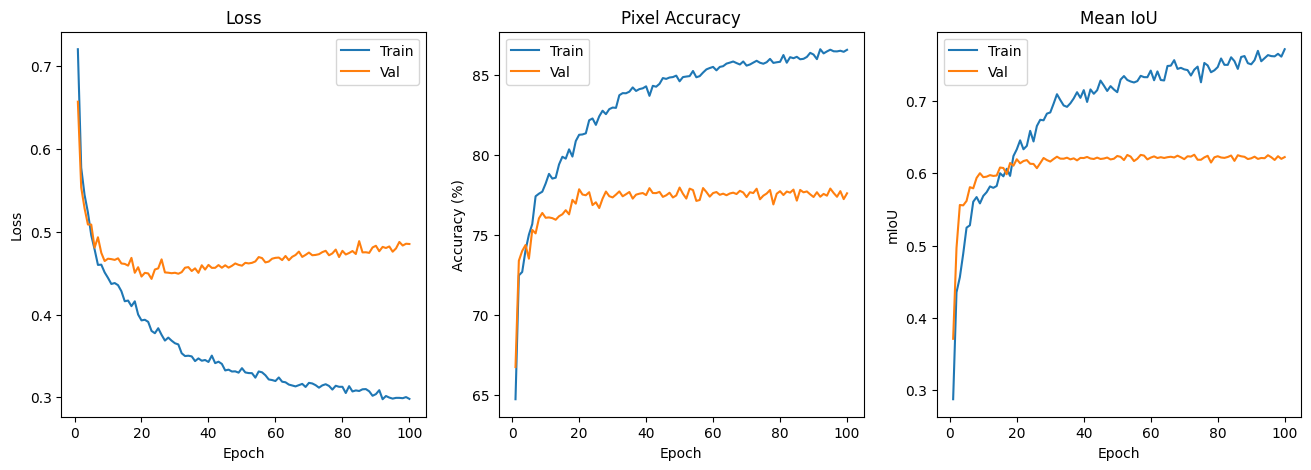

In [ ]:
epochs = range(1, num_epochs+1)
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, val_losses, label="Val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, [a*100 for a in train_accs], label="Train")
plt.plot(epochs, [a*100 for a in val_accs], label="Val")
plt.title("Pixel Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, train_ious, label="Train")
plt.plot(epochs, val_ious, label="Val")
plt.title("Mean IoU"); plt.xlabel("Epoch"); plt.ylabel("mIoU"); plt.legend()

plt.show()


Calling the trained model

In [ ]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, SegformerModel
import torch
import torch.nn as nn # Import nn
import os

# === Custom SegFormer with pretrained B2 backbone ===
class CustomSegFormer(nn.Module):
    def __init__(self, num_classes=4, id2label=None, label2id=None):
        super(CustomSegFormer, self).__init__()

        # === Pretrained Encoder (B2 backbone) ===
        self.encoder = SegformerModel.from_pretrained(
            "nvidia/segformer-b2-finetuned-ade-512-512",
            output_hidden_states=True
        )

        # B2 backbone hidden sizes
        embed_dim = [64, 128, 320, 512]
        decoder_dim = 256   # bottleneck channels for decoder

        # === Decoder Projections ===
        self.linear_c4 = nn.Conv2d(embed_dim[3], decoder_dim, kernel_size=1)
        self.linear_c3 = nn.Conv2d(embed_dim[2], decoder_dim, kernel_size=1)
        self.linear_c2 = nn.Conv2d(embed_dim[1], decoder_dim, kernel_size=1)
        self.linear_c1 = nn.Conv2d(embed_dim[0], decoder_dim, kernel_size=1)

        # Fuse and Classifier
        self.linear_fuse = nn.Conv2d(decoder_dim * 4, decoder_dim, kernel_size=1)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Conv2d(decoder_dim, num_classes, kernel_size=1)

    def forward(self, pixel_values):
        # === Encoder ===
        outputs = self.encoder(pixel_values)
        # tuple of 4 stages [C1, C2, C3, C4] in (B, C, H, W) format
        hidden_states = outputs.hidden_states

        # === Use hidden states directly (already in B, C, H, W) ===
        c1, c2, c3, c4 = hidden_states


        # === Decoder ===
        c1 = self.linear_c1(c1)
        c2 = self.linear_c2(c2)
        c3 = self.linear_c3(c3)
        c4 = self.linear_c4(c4)

        # Upsample to same spatial size as c1
        c2 = nn.functional.interpolate(c2, size=c1.shape[2:], mode="bilinear", align_corners=False)
        c3 = nn.functional.interpolate(c3, size=c1.shape[2:], mode="bilinear", align_corners=False)
        c4 = nn.functional.interpolate(c4, size=c1.shape[2:], mode="bilinear", align_corners=False)

        # Fuse features
        fused = torch.cat([c1, c2, c3, c4], dim=1)
        fused = self.linear_fuse(fused)
        fused = self.dropout(fused)

        # Final classifier head
        logits = self.classifier(fused)

        # Upsample back to original image resolution
        logits = nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

        return logits


# Path where you saved earlier
load_dir = "/content/drive/MyDrive/CustomB2_segformer_lulc"
model_save_path = os.path.join(load_dir, "model_state_dict.pth")


# Load trained model
# model = SegformerForSemanticSegmentation.from_pretrained(load_dir) # This expects specific files

# Instantiate your custom model
id2label = {0: "Urban", 1: "Water", 2: "Vegetation", 3: "Others"}
label2id = {v: k for k, v in id2label.items()}
model = CustomSegFormer(num_classes=4, id2label=id2label, label2id=label2id)

# Load the state dictionary
model.load_state_dict(torch.load(model_save_path))

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Load processor (assuming it was saved or you can re-instantiate)
# If you saved the processor using processor.save_pretrained(load_dir):
# processor = SegformerFeatureExtractor.from_pretrained(load_dir)
# If you didn't save it or used a custom dataset class:
from transformers import SegformerFeatureExtractor
processor = SegformerFeatureExtractor(do_resize=True, size=512)


print("✅ Trained model and processor loaded successfully!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

✅ Trained model and processor loaded successfully!


/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


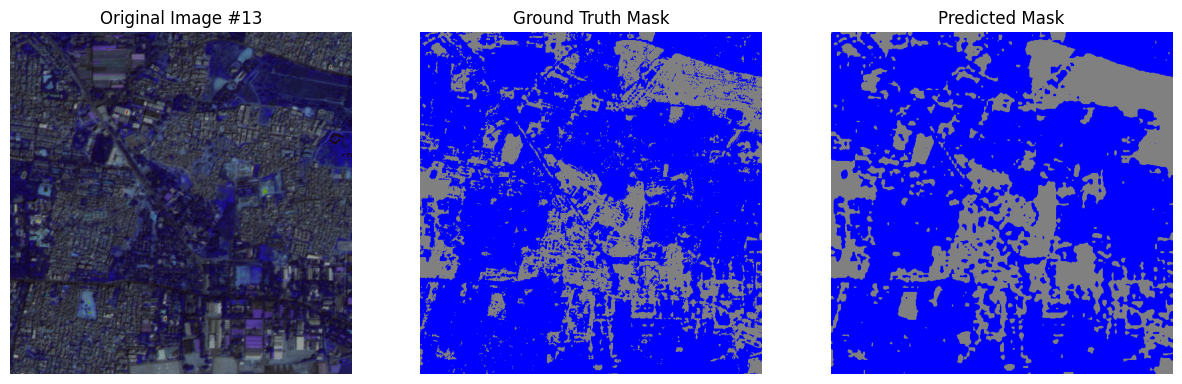

In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

# Color map for 4 classes
COLOR_MAP = {
    0: (255, 0, 0),     # Urban -> Red
    1: (0, 0, 255),     # Water -> Blue
    2: (0, 255, 0),     # Vegetation -> Green
    3: (128, 128, 128)  # Others -> Gray
}

def decode_color(mask_np):
    """Map class indices to RGB colors for visualization"""
    h, w = mask_np.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in COLOR_MAP.items():
        rgb[mask_np == cls] = color
    return rgb

# -------------------------------
# Inference for a specific index
# -------------------------------
model.eval()
idx = 13   # <-- choose any index here

# Make sure dataset returns correct pair
img, true_mask = val_dataset[idx]   # img: [3,512,512], true_mask: [512,512]
img_batch = img.unsqueeze(0).to(device)

with torch.no_grad():
    # outputs = model(pixel_values=img_batch)
    # pred_mask = torch.argmax(outputs.logits, dim=1).squeeze(0).cpu().numpy()
    logits = model(img_batch)
    pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()


# Convert tensors back for visualization
true_mask = true_mask.cpu().numpy()
img_vis = img.cpu().numpy()

# Undo normalization for display
mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std  = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
img_vis = (img_vis * std + mean).clip(0,1)
img_vis = np.transpose(img_vis, (1,2,0))  # CHW -> HWC

# -------------------------------
# Show results
# -------------------------------
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img_vis); plt.title(f"Original Image #{idx}"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(decode_color(true_mask)); plt.title("Ground Truth Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(decode_color(pred_mask)); plt.title("Predicted Mask"); plt.axis("off")
plt.show()

In [ ]:
save_dir = "/content/drive/MyDrive/CustomB2_segformer_lulc"

import os
import torch

os.makedirs(save_dir, exist_ok=True)

# Save trained model state dictionary
model_save_path = os.path.join(save_dir, "model_state_dict.pth")
torch.save(model.state_dict(), model_save_path)

# You can also save the processor if needed, but it's independent of the model
# processor.save_pretrained(save_dir) # This line caused an error earlier with LULCDataset

print(f"✅ Model state dictionary saved to {model_save_path}")
# print(f"✅ Processor config saved to {save_dir}")

✅ Model state dictionary saved to /content/drive/MyDrive/CustomB2_segformer_lulc/model_state_dict.pth
